In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load CSV
df = pd.read_csv("../recordings/pupil_hr_log.csv")

# Smooth the signal (optional)
df["pupil_radius"] = df["pupil_radius"].rolling(window=3, min_periods=1).mean()

# Create time series windows
def create_sequences(data, target, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

radius = df["pupil_radius"].values
hr = df["heart_rate"].values

# Normalize radius
scaler = MinMaxScaler()
radius = scaler.fit_transform(radius.reshape(-1, 1)).flatten()

X, y = create_sequences(radius, hr, window_size=30)
X = X[..., np.newaxis]  # Add channel dimension for CNN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
X

array([[[0.3657289 ],
        [0.22762148],
        [0.23273657],
        ...,
        [0.6342711 ],
        [0.64194373],
        [0.6342711 ]],

       [[0.22762148],
        [0.23273657],
        [0.22250639],
        ...,
        [0.64194373],
        [0.6342711 ],
        [0.64961637]],

       [[0.23273657],
        [0.22250639],
        [0.30434783],
        ...,
        [0.6342711 ],
        [0.64961637],
        [0.6342711 ]],

       ...,

       [[0.65217391],
        [0.62404092],
        [0.60358056],
        ...,
        [0.51918159],
        [0.57033248],
        [0.5370844 ]],

       [[0.62404092],
        [0.60358056],
        [0.61381074],
        ...,
        [0.57033248],
        [0.5370844 ],
        [0.51918159]],

       [[0.60358056],
        [0.61381074],
        [0.65217391],
        ...,
        [0.5370844 ],
        [0.51918159],
        [0.43222506]]])

In [7]:
y

array([75.88, 75.89, 75.9 , ..., 73.56, 73.6 , 73.61])

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten

model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(30, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Regression output
])

model.compile(
    optimizer='adam',
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
)
model.summary()


c:\Users\manit\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,041 (121.25 KB)

 Trainable params: 31,041 (121.25 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4280.9150 - mean_absolute_error: 62.1686 - val_loss: 251.3047 - val_mean_absolute_error: 14.1378
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 224.7780 - mean_absolute_error: 12.8834 - val_loss: 99.7019 - val_mean_absolute_error: 8.9688
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65.0237 - mean_absolute_error: 6.8161 - val_loss: 32.5700 - val_mean_absolute_error: 4.9012
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.9055 - mean_absolute_error: 3.5310 - val_loss: 22.6090 - val_mean_absolute_error: 4.2344
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.9948 - mean_absolute_error: 3.5892 - val_loss: 29.8738 - val_mean_absolute_error: 4.9418
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.5205 - mean_absolute_error: 3.2357 - val_loss: 31.6489 - val_mean_absolute_error: 5.1045
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.0364 - mean_absolute_error: 3.29

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


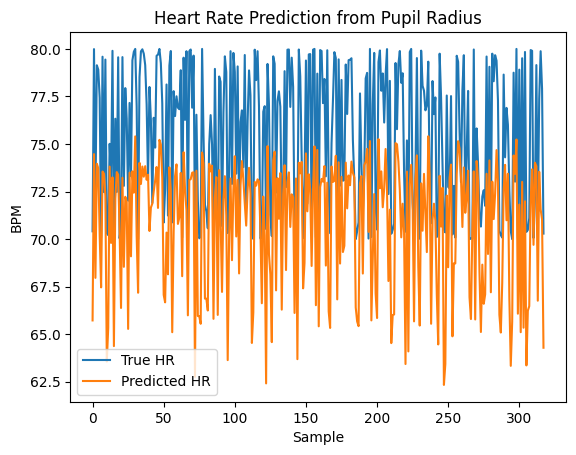

In [4]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).flatten()

plt.plot(y_test, label="True HR")
plt.plot(y_pred, label="Predicted HR")
plt.legend()
plt.title("Heart Rate Prediction from Pupil Radius")
plt.xlabel("Sample")
plt.ylabel("BPM")
plt.show()


In [5]:
model.save("../models/cnn.h5")